In [1]:
import tensorflow as tf
from tensorflow import keras
import resnet_V2
import matplotlib.pyplot as plt
from tqdm import tqdm

2022-01-05 09:30:50.346333: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
input_size = 256
batch_size = 32

ae = resnet_V2.ResNetAE()

2022-01-05 09:30:51.347538: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-05 09:30:51.423589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 09:30:51.424251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-05 09:30:51.424267: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-05 09:30:51.425498: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-05 09:30:51.426387: I tensorflow/stream_executor/platform/default/

In [4]:
def scaling(x):
    x = tf.cast(x, tf.float32) / 255.
    return x

In [7]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    './data/DOG',
    image_size=(input_size, input_size),
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.01,
    subset='training',
    seed=42)

test_ds = keras.preprocessing.image_dataset_from_directory(
    './data/DOG',
    image_size=(input_size, input_size),
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.01,
    subset='validation',
    seed=42)

train_ds = train_ds.map(scaling).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(scaling).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 15348 files belonging to 157 classes.
Using 15195 files for training.
Found 15348 files belonging to 157 classes.
Using 153 files for validation.


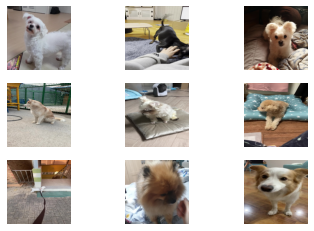

In [8]:
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

In [9]:
mse = keras.losses.MeanSquaredError()

@tf.function
def train_step(x, model, optimizer):
    with tf.GradientTape() as tape:
        recon = model(x)
        loss = mse(x, recon)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:
optimizer = keras.optimizers.Adam()
epochs =10

for epoch in range(1, epochs + 1):
    for train_x in tqdm(train_ds, desc=str(epoch)):
        train_step(train_x, ae, optimizer)
        
    loss = tf.keras.metrics.Mean()
    
    for test_x in test_ds:
        test_recon = ae(test_x)
        loss(mse(test_x, test_recon))
    print('epoch {} test loss {}\n'.format(epoch, loss.result()))

1: 100%|████████████████████████████████████████████████████████████| 475/475 [04:35<00:00,  1.73it/s]


epoch 1 test loss 0.015466230921447277



2: 100%|████████████████████████████████████████████████████████████| 475/475 [04:23<00:00,  1.80it/s]


epoch 2 test loss 0.010798071511089802



3: 100%|████████████████████████████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 3 test loss 0.009346170350909233



4: 100%|████████████████████████████████████████████████████████████| 475/475 [04:22<00:00,  1.81it/s]


epoch 4 test loss 0.008699472062289715



5: 100%|████████████████████████████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 5 test loss 0.00831248052418232



6: 100%|████████████████████████████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 6 test loss 0.008259950205683708



7: 100%|████████████████████████████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 7 test loss 0.007804268505424261



8: 100%|████████████████████████████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 8 test loss 0.008316260762512684



9: 100%|████████████████████████████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 9 test loss 0.007866421714425087



10: 100%|███████████████████████████████████████████████████████████| 475/475 [04:23<00:00,  1.80it/s]


epoch 10 test loss 0.007639588322490454



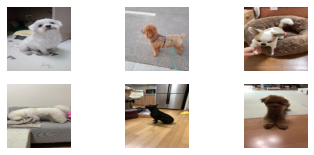

In [13]:
for images in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

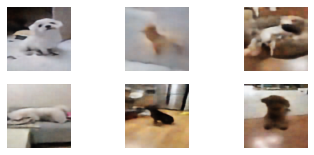

In [16]:
recon = ae(images)
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(recon[i].numpy())
    plt.axis('off')